In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import pycbc

In [3]:
use_spiir = 1
if use_spiir:
    skymap = np.loadtxt("skymap/skymap_spiirsnr_multires.txt")
else:
    skymap = np.loadtxt("skymap/skymap_manojsnr_multires.txt")

In [46]:
!pip install lalinference==2.0.4

ERROR: Could not find a version that satisfies the requirement lalinference==2.0.4 (from versions: none)
ERROR: No matching distribution found for lalinference==2.0.4


In [6]:
true_de = -0.408
ture_ra = 3.446

In [33]:
prob_density_without_null

array([1.28767227e-210, 1.28767227e-210, 1.28767227e-210, ...,
       8.96328215e-106, 8.96328215e-106, 8.96328215e-106])

In [36]:
np.savetxt('prob.txt',prob_density_without_null)

In [38]:
npix, len(prob_density_without_null)

(12582912, 12582912)

/home/qhu/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/home/qhu/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/home/qhu/anaconda3/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


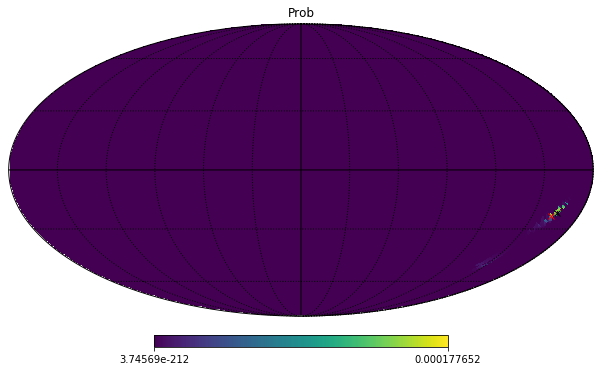

In [7]:
npix = np.shape(skymap[:,0])[0]
nside = int(np.sqrt(npix/12.0))
prob_density_without_null = np.exp(skymap[:,2])
prob_density_without_null = prob_density_without_null/np.sum(prob_density_without_null)
#max_theta,max_phi = hp.pixelfunc.pix2ang(nside,np.argmax(prob_density_without_null),nest=True)


max_theta,max_phi = hp.pixelfunc.pix2ang(nside,np.argmax(prob_density_without_null),nest=True)
projector  = hp.projector.MollweideProj()
x2,y2 = projector.ang2xy(np.array([max_theta,max_phi]))
x1,y1 = projector.ang2xy(np.array([-true_de+np.pi/2,ture_ra])) ##real direction
hp.mollview(prob_density_without_null,title='Prob',nest=True)
hp.graticule(coord='G',local=True)
plt.plot(x1,y1,'rx')
plt.plot(x2,y2,'kx')
plt.show()


In [14]:
import functools
import matplotlib
from distutils.version import LooseVersion
from matplotlib import text
from matplotlib import ticker
from matplotlib import patheffects
from matplotlib import rcParams

def find_greedy_credible_levels(p, ranking=None):
    p = np.asarray(p)
    pflat = p.ravel()
    if ranking is None:
        ranking = pflat
    else:
        ranking = np.ravel(ranking)
    i = np.flipud(np.argsort(ranking))
    cs = np.cumsum(pflat[i])
    cls = np.empty_like(pflat)
    cls[i] = cs
    return cls.reshape(p.shape)


def heatmap(func, *args, **kwargs):
    "Plot a function on the sphere using the current geographic projection."""
    from matplotlib import pyplot as plt

    # Get current axis.
    ax = plt.gca()

    # Set up a regular grid tiling the bounding box of the axes.
    x = np.arange(ax.bbox.x0, ax.bbox.x1 + 0.5, 0.5)
    y = np.arange(ax.bbox.y0, ax.bbox.y1 + 0.5, 0.5)
    xx, yy = np.meshgrid(x, y)

    # Get axis data limits.
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # Retrieve the inverse transform of the current axes (which converts
    # display coodinates to data coordinates).
    itrans = ax.transData.inverted()

    # Get the longitude and latitude of every point in the bounding box.
    lons, lats = itrans.transform(np.column_stack((xx.ravel(), yy.ravel()))).T

    # Create a mask that selects only the pixels that fall inside the map
    # boundary.
    mask = \
        np.isfinite(lons) & np.isfinite(lats) & (lons >= xmin) & (lons <= xmax)
    zz = np.ma.array(np.empty(lons.shape), mask=~mask)

    # Evaluate the function everywhere that the mask is set.
    zz[mask] = func(lons[mask], lats[mask])

    # Plot bitmap using imshow.
    if LooseVersion(matplotlib.__version__) < LooseVersion('2.0'):
        # FIXME: workaround for old behavior of imshow().
        # Remove this once we require matplotlib >= 2.0.
        # See also:
        #   * https://bugs.ligo.org/redmine/issues/5152
        #   * https://github.com/matplotlib/matplotlib/issues/7903
        aximg = plt.imshow(
            zz.reshape(xx.shape), aspect=ax.get_aspect(),
            interpolation='nearest',
            origin='upper', extent=(xmin, xmax, ymax, ymin), *args, **kwargs)
    else:
        aximg = plt.imshow(
            zz.reshape(xx.shape), aspect=ax.get_aspect(),
            interpolation='nearest',
            origin='upper', extent=(0, 1, 1, 0), transform=ax.transAxes,
            *args, **kwargs)

    # Hide masked-out values by displaying them in transparent white.
    aximg.cmap.set_bad('w', alpha=0.)

    # Done.
    return aximg


def contour(func, *args, **kwargs):
    "Plot a function on the sphere using the current geographic projection."""
    from matplotlib import pyplot as plt

    # Get current axis.
    ax = plt.gca()

    # Set up a regular grid tiling in right ascension and declination
    x = np.linspace(*ax.get_xlim(), num=500)
    y = np.linspace(*ax.get_ylim(), num=500)
    xx, yy = np.meshgrid(x, y)

    # Evaluate the function everywhere.
    zz = func(xx, yy)

    # Add contour plot
    ax = plt.contour(xx, yy, zz, *args, **kwargs)

    # Done.
    return ax

def healpix_heatmap(map, *args, **kwargs):
    """Produce a heatmap from a HEALPix map."""
    mpl_kwargs = dict(kwargs)
    dlon = mpl_kwargs.pop('dlon', 0)
    nest = mpl_kwargs.pop('nest', False)
    return heatmap(
        functools.partial(_healpix_lookup, map, nest=nest, dlon=dlon),
        *args, **mpl_kwargs)


def healpix_contour(map, *args, **kwargs):
    """Produce a contour plot from a HEALPix map."""
    mpl_kwargs = dict(kwargs)
    dlon = mpl_kwargs.pop('dlon', 0)
    nest = mpl_kwargs.pop('nest', False)
    return contour(
        functools.partial(_healpix_lookup, map, nest=nest, dlon=dlon),
        *args, **mpl_kwargs)

def _healpix_lookup(map, lon, lat, nest=False, dlon=0):
    """Look up the value of a HEALPix map in the pixel containing the point
    with the specified longitude and latitude."""
    nside = hp.npix2nside(len(map))
    return map[hp.ang2pix(nside, 0.5 * np.pi - lat, lon - dlon, nest=nest)]

In [29]:
hp.ang2pix?

Signature: hp.ang2pix(nside, theta, phi, nest=False, lonlat=False)
Docstring:
ang2pix : nside,theta[rad],phi[rad],nest=False,lonlat=False -> ipix (default:RING)

Parameters
----------
nside : int, scalar or array-like
  The healpix nside parameter, must be a power of 2, less than 2**30
theta, phi : float, scalars or array-like
  Angular coordinates of a point on the sphere
nest : bool, optional
  if True, assume NESTED pixel ordering, otherwise, RING pixel ordering
lonlat : bool
  If True, input angles are assumed to be longitude and latitude in degree,
  otherwise, they are co-latitude and longitude in radians.

Returns
-------
pix : int or array of int
  The healpix pixel numbers. Scalar if all input are scalar, array otherwise.
  Usual numpy broadcasting rules apply.

See Also
--------
pix2ang, pix2vec, vec2pix

Examples
--------
Note that some of the test inputs below that are on pixel boundaries
such as theta=pi/2, phi=pi/2, have a tiny value of 1e-15 added to them
to make them re

In [8]:
deg2perpix = hp.nside2pixarea(nside, degrees=True)
probperdeg2 = prob_density_without_null / deg2perpix


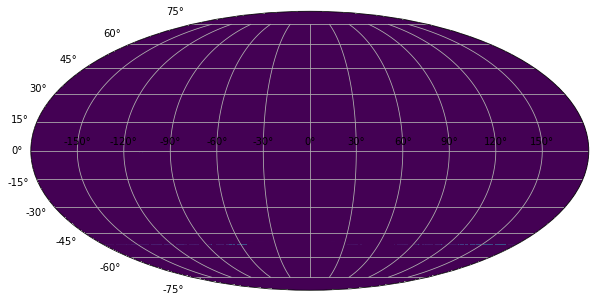

In [32]:
fig = plt.figure(figsize=(10,6), frameon=False)
#ax = plt.axes(projection='mollweide' if opts.geo else 'astro hours mollweide')
ax = plt.axes(projection='mollweide')
ax.grid()

dlon = 3.554
vmax = probperdeg2.max()
healpix_heatmap(probperdeg2, dlon=dlon, vmin=0., vmax=vmax) #nest=metadata['nest']

cls = 100 * find_greedy_credible_levels(prob_density_without_null)
cs = healpix_contour(
        cls, dlon=dlon, nest=True,
        colors='k', linewidths=0.5, levels=90)
fmt = r'%g\%%' if rcParams['text.usetex'] else '%g%%'
plt.clabel(cs, fmt=fmt, fontsize=6, inline=True)
